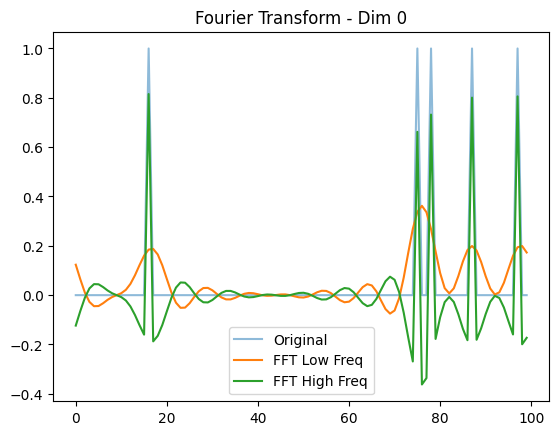

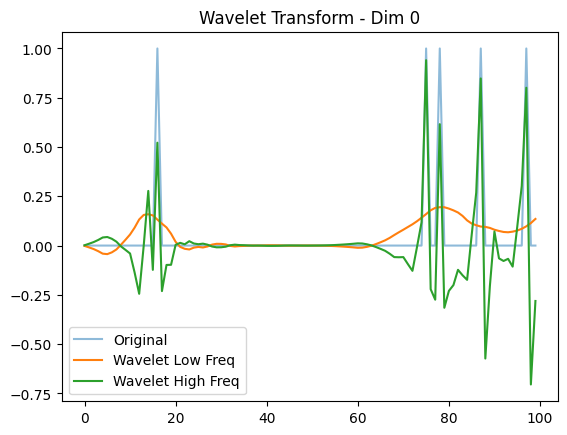

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import pywt

# 模拟一个蛋白质序列 embedding: 200个氨基酸, 每个128维
np.random.seed(42)
# embedding = np.random.randn(200, 128)  # (N, D)
# 假设一个序列长度 N=100 的 one-hot 编码：每行是20维
N = 100
embedding = np.eye(20)[np.random.choice(20, size=N)]  # shape (100, 20)

def fourier_multiscale(embedding, keep_ratio=0.1):
    N, D = embedding.shape
    fft_coeffs = fft(embedding, axis=0)  # 频谱 (复数)
    
    # 保留低频部分（前 keep_ratio），置零高频
    low_pass = np.copy(fft_coeffs)
    cutoff = int(N * keep_ratio)
    low_pass[cutoff:-cutoff] = 0
    low_signal = np.real(ifft(low_pass, axis=0))

    # 保留高频部分（去除中心）
    high_pass = np.copy(fft_coeffs)
    high_pass[:cutoff] = 0
    high_pass[-cutoff:] = 0
    high_signal = np.real(ifft(high_pass, axis=0))
    
    return low_signal, high_signal

def wavelet_multiscale(embedding, wavelet='db4', level=3):
    N, D = embedding.shape
    low_scale = np.zeros_like(embedding)
    high_scale = np.zeros_like(embedding)

    for d in range(D):
        # 小波分解
        coeffs = pywt.wavedec(embedding[:, d], wavelet, level=level)
        
        # 重构低频（A）
        A = coeffs[0]
        low = pywt.upcoef('a', A, wavelet, level=level, take=N)
        
        # 重构高频（所有D细节层叠加）
        D_sum = np.zeros_like(embedding[:, d])
        for i in range(1, len(coeffs)):
            Di = pywt.upcoef('d', coeffs[i], wavelet, level=level-i+1, take=N)
            D_sum += Di

        low_scale[:, d] = low
        high_scale[:, d] = D_sum
    
    return low_scale, high_scale

low_f, high_f = fourier_multiscale(embedding)
low_w, high_w = wavelet_multiscale(embedding)

# 画一个维度对比（例如第0维）
dim = 0
plt.plot(embedding[:, dim], label='Original', alpha=0.5)
plt.plot(low_f[:, dim], label='FFT Low Freq')
plt.plot(high_f[:, dim], label='FFT High Freq')
plt.title('Fourier Transform - Dim 0')
plt.legend()
plt.show()

plt.plot(embedding[:, dim], label='Original', alpha=0.5)
plt.plot(low_w[:, dim], label='Wavelet Low Freq')
plt.plot(high_w[:, dim], label='Wavelet High Freq')
plt.title('Wavelet Transform - Dim 0')
plt.legend()
plt.show()
